In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

import sys
print (sys.version)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


In [14]:
#constants, from paper
# H_0 = 2e-17
H_0 = 2e-18 
m_gw = 1e10 * H_0 #Hz
#(1 / 6.5822) * 10^25 hz = 1 GeV

h = 0.71
omega_r = 4.15e-5 / h**2
omega_m = 0.1344 / h**2
omega_l = 0.734

k_0 = H_0 * 1e10
k_c = H_0 * 1e4

eta_star = 2 * np.sqrt(omega_r) / (H_0 * omega_m)
eta_eq = eta_star * (np.sqrt(2) - 1)
eta_0 = 0.879 * 2 / (H_0 * np.sqrt(omega_m))

def gev_to_hz(gev):
    return gev * (1 / 6.5822) * 1e25
def hz_to_gev(hz):
    return hz * 6.5822 * 1e-25

print(eta_star, eta_eq, eta_0)

3.4031659583239732e+16 1.4096374949442212e+16 1.702345038967256e+18


In [13]:
#functions

def a(eta):
    if eta < eta_eq:
        return H_0 * np.sqrt(omega_r) * eta #RD
    else:
        return ((np.sqrt(omega_r) + (H_0 * omega_m * eta / 2) )**2 - omega_r) / omega_m #MD
#         return 0.25 * H_0**2 * omega_m * eta**2
    
def H(eta):
    return H_0 * np.sqrt( (omega_r / a(eta)**4) + (omega_m / a(eta)**3) + omega_l )

def a_prime(eta):
    if eta < eta_eq:
        return H_0 * np.sqrt(omega_r)
    else:
        return H_0 * ((H_0 * omega_m * eta / 2) + np.sqrt(omega_r))
#         return 0.5 * H_0**2 * omega_m * eta


def omega(k, eta):
    return np.sqrt((k**2 / a(eta)**2) + m_gw**2)

#determine horizon crossing conf. time
def eta_k(k, eta_range):
    H_vals = np.vectorize(H)(eta_range)
    omega_vals = np.vectorize(omega)(k, eta_range)
    loc = np.where(np.diff(np.sign(H_vals - omega_vals)))
    return eta_range[loc]

# def gamma_analytic(k, eta):
#     #determine eta cross time
#     eta_cross = eta_k(k, np.logspace(10, ))
    
#helper function for solve_ivp
def deq_helper(k, m):
    def wrapper(eta, y):
        g = y[0]
        v = y[1]
        return [v, -v * (2 * a_prime(eta) / a(eta)) - g * (k**2 + (a(eta) * m)**2)]
    return wrapper

#main simulator function
def simulator(pltTogether, analytic, m, kList, colorList, confTimeTuple, deriv_func, x_label, y_label, title):
    if not pltTogether:
        sc = 8
        plt.figure(figsize=(sc * 2, sc * 1))
        plt.xscale('log', base = 10)
        plt.xlabel(x_label, fontsize = 15)
        plt.ylabel(y_label, fontsize = 15)
        plt.title(title, fontsize = 15)
    
    #range of eta values
    ct_range = np.logspace(confTimeTuple[0], confTimeTuple[1], confTimeTuple[2])
    
    #plotting the passed in k values
    for i in range(len(kList)):        
        sol = solve_ivp(deriv_func(kList[i], m), t_span = [ct_range[0], ct_range[-1]], y0 = [1,0], t_eval = ct_range)
        labl = "k = " + str(kList[i]) + ", " + ("GR" if m == 0 else "MG")
        plt.plot(sol.t, sol.y[0], colorList[i], label = labl)
        
        if analytic:
            eta_cross = eta_k(kList[i], ct_range)
            loc = np.where(ct_range == eta_cross)[0][0]
#             plt.axvline(x = ct_range[loc], color = 'g', label = 'cross')
            gamma = np.sqrt((omega(kList[i], eta_cross) / np.vectorize(omega)(kList[i], ct_range)) * (a(eta_cross) / np.vectorize(a)(ct_range))**3 )
            #chop off values before crossing
            plt.plot(ct_range[loc:], gamma[loc:], colorList[i] + ".", label = "k = " + str(kList[i]) + ", analytic")
        
    #plot legend
    plt.legend()


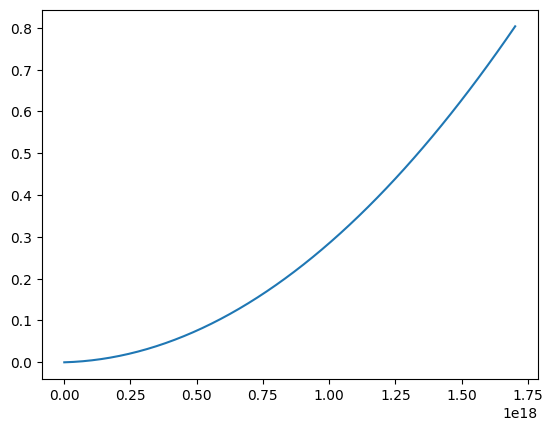

In [21]:
#testing a, H

etas = np.linspace(1, eta_0)
a_vals = np.vectorize(a)(etas)
plt.plot(etas, a_vals)
# om_func = np.vectorize(omega)

# h_fin = h_func(etas)
# om_fin = om_func(k_c, etas)

# sc = 8
# plt.figure(figsize=(sc * 2, sc * 1))
# plt.xscale('log', base = 10)

# plt.plot(etas, om_fin - h_fin, "b-")
# plt.plot(etas, om_fin * 0, "k-")

# loc = np.where(np.diff(np.sign(h_fin - om_fin)))

# plt.axvline(x = etas[loc], color = 'g', label = 'cross')

# print(etas[loc])
# print(eta_k(k_c, etas))

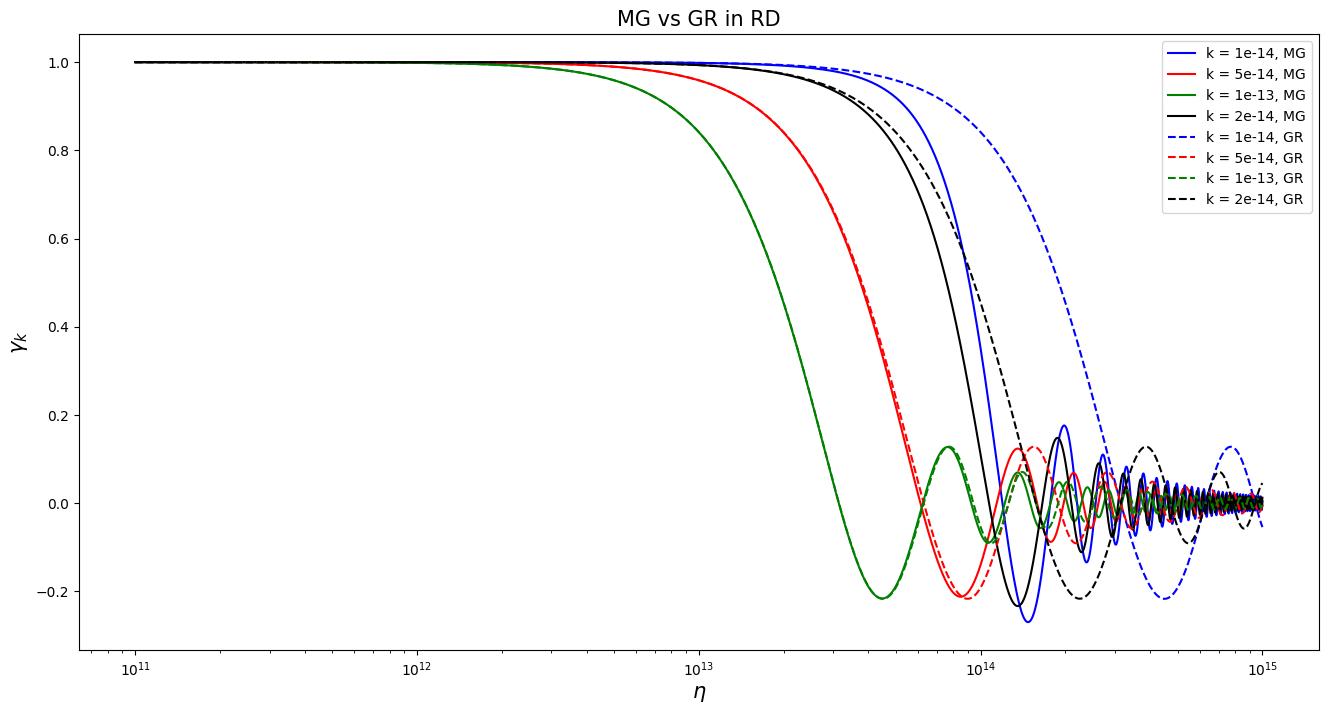

In [17]:
simulator(False, False, m_gw, [1e-14, 5e-14, 1e-13, k_c], ["b-", "r-", "g-", "k-"], (11, 15, 5000), deq_helper, r"$\eta$", r"$\gamma_{k}$", "MG vs GR in RD")
simulator(True, False, 0, [1e-14, 5e-14, 1e-13, k_c], ["b--", "r--", "g--", "k--"], (11, 15, 5000), deq_helper, "", "", "")

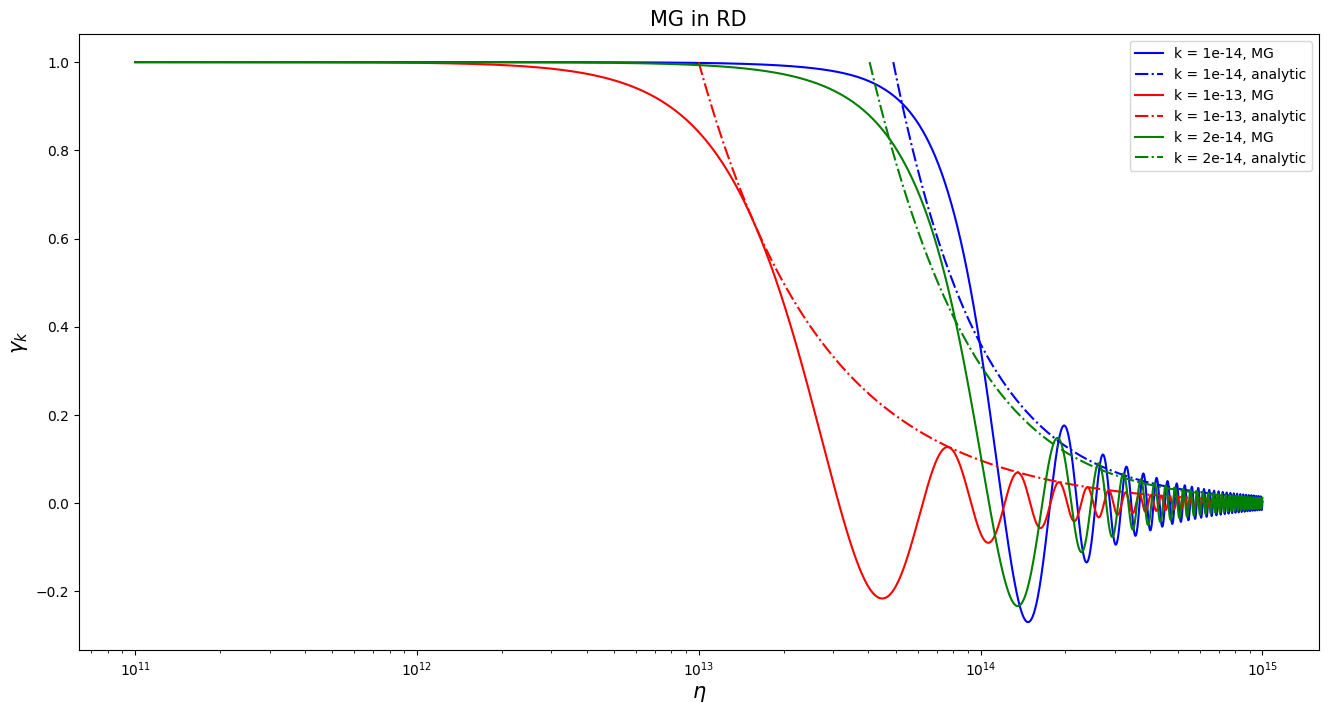

In [18]:
#testing analytic solution

simulator(False, True, m_gw, [1e-14, 1e-13, k_c], ["b-", "r-", "g-"], (11, 15, 5000), deq_helper, r"$\eta$", r"$\gamma_{k}$", "MG in RD")

# etas = np.logspace(11, 15, 5000)
# eta_kc = eta_k(k_c, etas)
# loc = np.where(etas == eta_kc)[0][0]
# print(loc)

# gamma = np.sqrt((omega(k_c, eta_kc) / np.vectorize(omega)(k_c, etas)) * (a(eta_kc) / np.vectorize(a)(etas))**3 )
# plt.plot(etas[loc:], gamma[loc:], "r-")